#### ✅ Note
앞선 분석(1-1)에서 배송 지연 시 평점이 약 2.0점 하락함을 확인 <br>
본 분석에서는 구체적인 골든타임(Golden Time)을 탐색

## 📌 Hypothesis
> "배송 지연 일수가 증가할수록 고객 리뷰 평점은 하락하며,<br>
특정 지연 일수 이후부터 만족도 하락이 통계적으로 유의해질 것이다."

## 📌 Data Scope & Unit of Analysis
- 분석 단위: 주문(order_id) 기준
- 주문 상태가 'delivered'인 건만 분석 대상에 포함
- 리뷰 데이터는 order_id 기준으로 집계하여 1행 = 1주문이 되도록 정규화
- 지연일이 31일 이하 건만 분석 대상에 포함

## 📌 Metric Definition
- delay_sec: 실제 배송 시각 − 예상 배송일의 마감 시각
- delay_days: delay_sec를 기준으로 24시간 미만 지연도 1일로 계산 (ceiling)
- review_score: 고객 리뷰 평점 (1~5)
- low_score: 리뷰 점수 ≤ 2 여부

## 📌 Data Validation
- timestamp 결측 재검증
- is_late 라벨 검증 (delay_days > 0)

## 📌 Statistical Validation
- 표본 수, 평균, 중앙값
- Welch t-test + Cohen’s d
- 신뢰구간 (CI) 시각화

## 📌 Analysis
1. Delay bucket별 리뷰 분포 탐색
    - Delay bucket 그룹별 평균·중앙값 비교
    - 그룹별 저평점 리뷰 비율 산출
    - 평균 평점 분포 및 저평점 비율 시각화
2. 지연 일수별 고객 만족도 변화 분석
    - 배송 지연일수에 따른 평균 평점, 저평점 비율, 표본 수 확인
    - 지연 일수 증가에 따른 고객 만족도 변화 추이 시각화
3. 임계점 후보(≤1일 vs ≥2일) 검증
    - 두 그룹 간 평균 평점 차이 t-test 수행
    - 효과크기(Cohen’s d): 평균 차이 실질적 크기 확인
    - 98% 신뢰구간 (CI) 시각화로 임계점 가설 일관성 확인

In [ ]:
import pandas as pd
import numpy as np
import sqlite3

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [ ]:
# 데이터 불러오기
path = '/content/drive/MyDrive/Data Analysis/prj1-olist-ecommerce'

df = pd.read_csv(f"{path}/datasets/processed/olist_orders_enriched.csv")

In [ ]:
# 데이터 확인
display(df.sample(5))
display(df.info())

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_cnt,estimated_deadline,is_late
14747,a9748189a6d0793f59bc792194cf6e16,delivered,2018-03-22 14:48:14,2018-04-10 13:51:47,2018-04-23,5.0,1.0,2018-04-23 23:59:59,0
46070,011667ae100a333a3051c9a23e3f0283,delivered,2017-11-29 10:42:47,2017-12-07 23:22:39,2017-12-20,5.0,1.0,2017-12-20 23:59:59,0
48863,14be0a96bf13d58196fd144c4b086fe4,delivered,2018-02-28 13:42:08,2018-03-14 16:02:08,2018-03-26,3.0,1.0,2018-03-26 23:59:59,0
55691,1587f0c11595ff02ca8f9219568ef020,delivered,2017-09-13 11:38:29,2017-10-11 11:54:11,2017-10-10,5.0,1.0,2017-10-10 23:59:59,1
27070,a2b641f30be1e5a530738ffe99633544,delivered,2017-05-19 18:35:57,2017-05-31 09:44:04,2017-06-12,4.0,1.0,2017-06-12 23:59:59,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95824 entries, 0 to 95823
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       95824 non-null  object 
 1   order_status                   95824 non-null  object 
 2   order_purchase_timestamp       95824 non-null  object 
 3   order_delivered_customer_date  95824 non-null  object 
 4   order_estimated_delivery_date  95824 non-null  object 
 5   review_score                   95824 non-null  float64
 6   review_cnt                     95824 non-null  float64
 7   estimated_deadline             95824 non-null  object 
 8   is_late                        95824 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 6.6+ MB


None

In [ ]:
# timestamp 타입 변환
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['estimated_deadline'] = pd.to_datetime(df['estimated_deadline'])

In [ ]:
# 핵심 컬럼 결측 재검증
key_cols = ['order_purchase_timestamp', 'order_delivered_customer_date','order_estimated_delivery_date','review_score']
print(df[key_cols].isna().mean().sort_values(ascending=False))

order_purchase_timestamp         0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
review_score                     0.0
dtype: float64


## 1. Delay bucket별 리뷰 분포 탐색

In [ ]:
# 배송 지연 초 단위 계산
df['delay_sec'] = (df['order_delivered_customer_date'] - df['estimated_deadline']).dt.total_seconds()

# 배송 지연 일수 계산 (지연: 올림 / 조기배송: 내림)
df['delay_days'] = np.where(
    df['delay_sec'] > 0
    , np.ceil(df['delay_sec'] / 86400)
    , np.where(
        df['delay_sec'] < 0
        , (df['delay_sec'] / 86400).astype(int)
        , 0
    )
).astype(int)

#### ✅ 배송 지연일(delay_days) 파생 컬럼 생성
delay_days는 배송 예정일 대비 실제 배송 시점을 기준으로 계산
- 지연 배송의 경우 고객 체감 기준으로 24시간 미만도 1일로 올림 계산
- 조기 배송의 경우 24시간 이내는 0일로 간주, <br>
  하루 이상 빠른 경우에만 음수 일수로 반영
  
※ 24시간 미만 지연이라도 날짜가 넘어가는 순간 고객의 부정적 경험을 발생한다고 가정하여 올림(ceiling) 처리함

In [ ]:
# delay bucket 생성
def delay_bucket_by_days(days):
    if pd.isna(days):
        return None
    elif days <= 0:
        return 'On-time'
    elif days == 1:
        return '1 day'
    elif days == 2:
        return '2 days'
    elif 3 <= days <= 5:
        return '3-5 days'
    elif 6 <= days <= 10:
        return '6-10 days'
    else:
        return '10+ days'

df['delay_bucket'] = df['delay_days'].apply(delay_bucket_by_days)

In [ ]:
# bucket 순서 고정
bucket_order = [
    'On-time'
    , '1 day'
    , '2 days'
    , '3-5 days'
    , '6-10 days'
    , '10+ days'
]

df['delay_bucket'] = pd.Categorical(
    df['delay_bucket']
    , categories=bucket_order
    , ordered=True
)

In [ ]:
# delay bucket별 평점 평균, 중앙값 확인
bucket_summary = (
    df[df['review_score'].notna()].groupby('delay_bucket').agg(
        avg_review = ('review_score', 'mean')
        , median_review = ('review_score', 'median')
        , cnt = ('review_score', 'count')
    )
).reset_index()

bucket_summary = bucket_summary.sort_values('delay_bucket').reset_index(drop=True)

bucket_summary

/tmp/ipython-input-1220206250.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['review_score'].notna()].groupby('delay_bucket').agg(


,delay_bucket,avg_review,median_review,cnt
0,On-time,4.290589,5.0,89443
1,1 day,3.731707,4.0,820
2,2 days,3.179104,4.0,536
3,3-5 days,2.468155,2.0,1366
4,6-10 days,1.772644,1.0,1634
5,10+ days,1.710864,1.0,2025


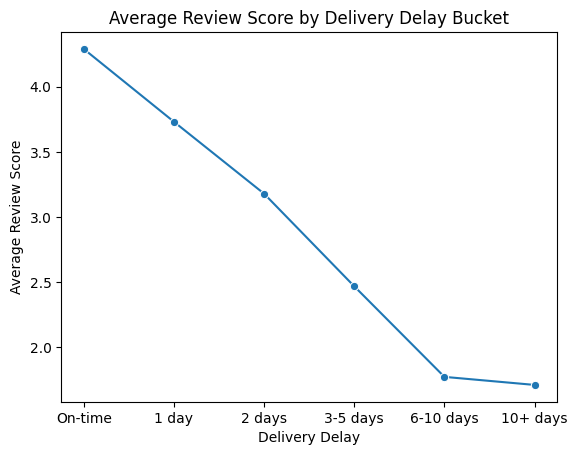

In [ ]:
# delay bucket별 평점 평균 시각화 (lineplot)
sns.lineplot(
    data = bucket_summary
    , x = 'delay_bucket'
    , y = 'avg_review'
    , marker = 'o'
)

plt.title('Average Review Score by Delivery Delay Bucket')
plt.xlabel('Delivery Delay')
plt.ylabel('Average Review Score')
plt.show()

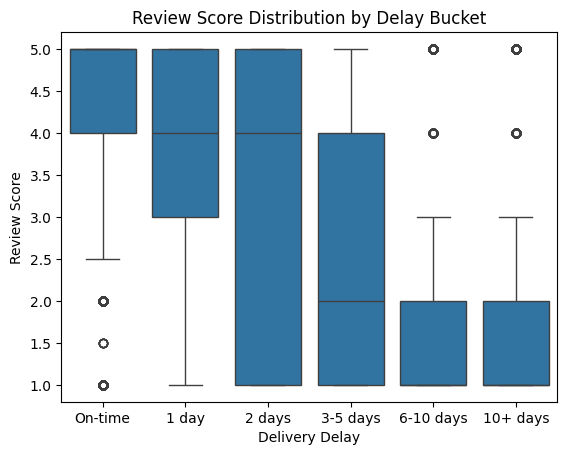

In [ ]:
# delay bucket별 평점 평균 분포 (boxplot)
sns.boxplot(
    data=df[df['review_score'].notna()]
    , x='delay_bucket'
    , y='review_score'
    , order = bucket_order

)

plt.title('Review Score Distribution by Delay Bucket')
plt.xlabel('Delivery Delay')
plt.ylabel('Review Score')
plt.show()

In [ ]:
# 저평점 리뷰 여부 판단
df['low_score'] = (df['review_score'] <= 2).astype(int)

# 저평점 리뷰 비율 계산
low_ratio = (
    df[df['review_score'].notna()]
    .groupby('delay_bucket')
    .agg(low_ratio=('low_score', 'mean'))
    .reset_index()
)

/tmp/ipython-input-3829338073.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('delay_bucket')


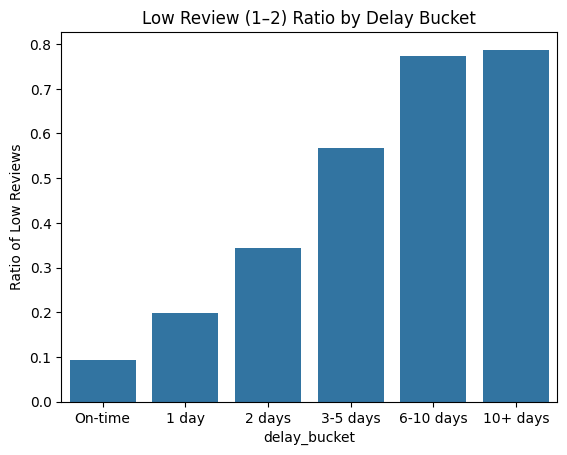

In [ ]:
# barplot: delay bucket별 저평점 리뷰 비율 시각화
sns.barplot(
    data=low_ratio
    , x='delay_bucket'
    , y='low_ratio'
    , order = bucket_order
)

plt.title('Low Review (1–2) Ratio by Delay Bucket')
plt.ylabel('Ratio of Low Reviews')
plt.show()

#### ✅ Delay bucket -> 하루 단위 추가 분석 필요
배송 지연이 발생할수록 고객 만족도는 전반적으로 하락함<br>
명확한 임계점 확인을 위해 지연일 단위의 추가 분석을 수행<br>

## 2. 지연 일수별 고객 만족도 변화 분석

In [ ]:
# is_late와 delay_days 정의 일관성 확인
check = df[['delay_days', 'is_late']].dropna()
pd.crosstab(
    check['is_late'],
    check['delay_days'] > 0
)

delay_days,False,True
is_late,,
0,89443,0
1,0,6381


#### ✅ 지연 배송을 is_late == 1로 정의
is_late 라벨은 delay_sec > 0 (예상 배송일 초과) 기준과 완전히 일치함을 확인


In [ ]:
# 분석 대상 설정: 배송 지연이 발생한 주문만
df_delay = df[
    (df['is_late'] == 1) &
    (df['review_score'].notna())
].copy()

In [ ]:
# 지연일 분포 확인
display(df_delay['delay_days'].describe(percentiles=[0.95, 0.99]))

,delay_days
count,6381.000000
mean,10.518414
std,14.462659
min,1.000000
50%,7.000000
95%,31.000000
99%,70.000000
max,188.000000


#### ✅ 극단값 처리: 분석 목적에 따른 범위 한정
전체 지연 주문의 95%는 31일 이내, 99%는 70일 이내<br>
95% 이후 구간의 지연 폭이 급격히 증가하며, 상위 5%는 극단값이 포함될 가능성이 높아 임계점 탐색의 안정성을 위해 제외
<br><br>
=> 31일 초과 지연은 이미 고객 만족도가 바닥인 사고(incident)의 영역<br>
본 분석의 목적은 사고 관리가 아니라 일반적 지연 상황에서의 임계점 탐색이므로<br>
분석 범위를 31일 이내로 한정함<br><br>
(※ 컷오프 기준 변경 시에도 임계점 결론의 일관성 여부는
민감도 분석을 통해 추가 검증 가능)

In [ ]:
# 분석 목적에 따른 범위 한정: 31일 초과 건 제외
df_delay_trim = df_delay[df_delay['delay_days'] <= 31]

In [ ]:
# 제외 전/후 비교

# before
display(df_delay['review_score'].mean())

# after
display(df_delay_trim['review_score'].mean())

np.float64(2.2718225983388183)

np.float64(2.279697268838434)

In [ ]:
# 배송일에 따른 평점 평균, 저평점 비율, 표본 수 집계
day_summary = (
    df_delay_trim.groupby('delay_days').agg(
        avg_review = ('review_score', 'mean')
        , low_ratio = ('low_score', 'mean')
        , cnt = ('review_score', 'count')
    ).reset_index().sort_values('delay_days')
)

day_summary.head()

,delay_days,avg_review,low_ratio,cnt
0,1,3.731707,0.197561,820
1,2,3.179104,0.343284,536
2,3,2.683468,0.504032,496
3,4,2.497706,0.559633,436
4,5,2.192396,0.645161,434


In [ ]:
# 평점 평균 및 저평점 비율 변화량 계산
day_summary['avg_review_delta'] = day_summary['avg_review'].diff()
day_summary['low_ratio_delta'] = day_summary['low_ratio'].diff()

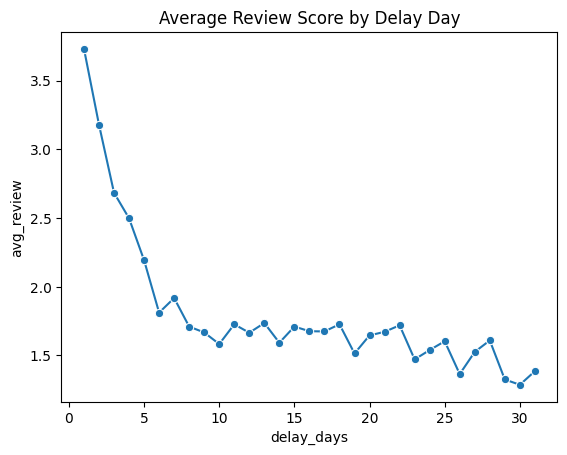

In [ ]:
# 배송 지연일에 따른 평점 평균 (lineplot)
sns.lineplot(
    data=day_summary
    , x='delay_days'
    , y='avg_review'
    , marker='o'
)

plt.title('Average Review Score by Delay Day')
plt.show()

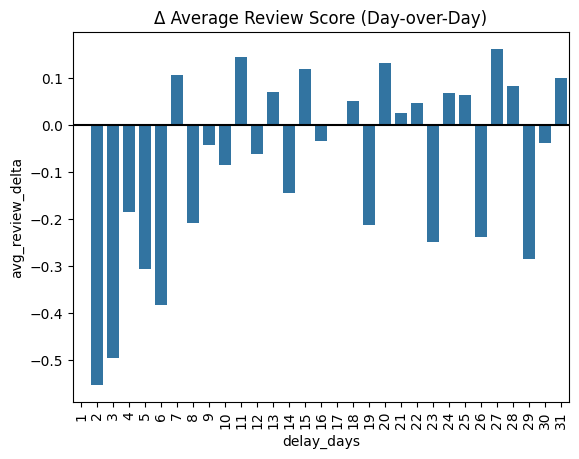

In [ ]:
# 배송 지연일에 따른 평점 평균 변화량 (barplot)
sns.barplot(
    data=day_summary
    , x='delay_days'
    , y='avg_review_delta'
)

plt.xticks(rotation=90)
plt.axhline(0, color='black')
plt.title('Δ Average Review Score (Day-over-Day)')
plt.show()

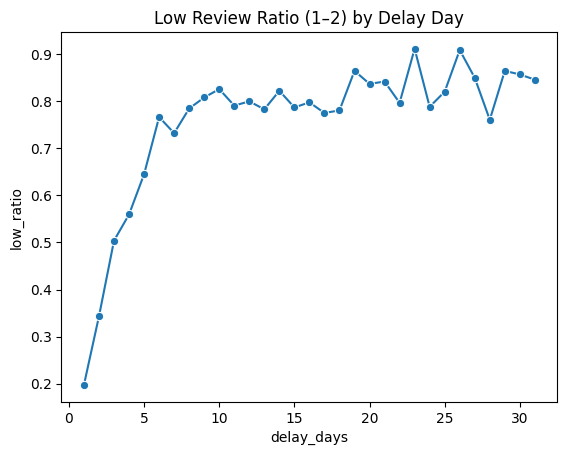

In [ ]:
# 저평점 리뷰 비율 변화 (lineplot)
sns.lineplot(
    data=day_summary
    , x='delay_days'
    , y='low_ratio'
    , marker='o'
)

plt.title('Low Review Ratio (1–2) by Delay Day')
plt.show()

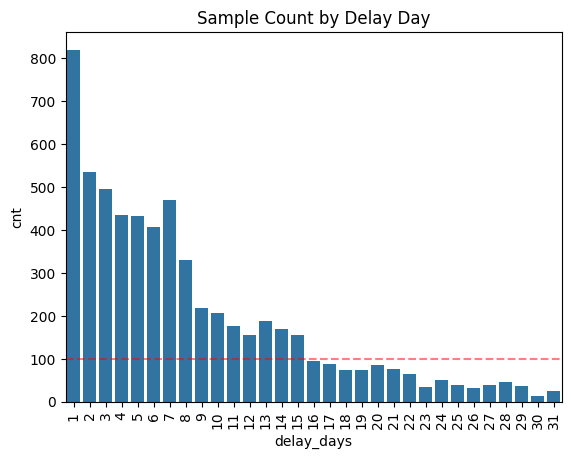

In [ ]:
# 표본 수 검증 (barplot)
sns.barplot(
    data=day_summary
    , x='delay_days'
    , y='cnt'
)

plt.axhline(100, color='red', linestyle='--', alpha=.5)
plt.xticks(rotation = 90)
plt.title('Sample Count by Delay Day')
plt.show()

#### ✅ 임계점 후보: 배송 지연 2일
- 배송 지연 1일차부터 만족도 하락이 시작됨
- day-over-day 변화량과 저평점 비율 증가는 2일차 구간에서 가장 큼

=> 배송 지연 2일차가 고객 인식이 구조적으로 변화하는 첫 번째 변곡점이라 판단됨


## 3. 임계점 후보(≤1일 vs ≥2일) 검증

In [ ]:
# 그룹 정의
group_1 = df_delay_trim[df_delay_trim['delay_days'] <= 1]['review_score']
group_2 = df_delay_trim[df_delay_trim['delay_days'] >= 2]['review_score']

In [ ]:
# 표본 수
n1, n2 = len(group_1), len(group_2)

# 평균
mean1, mean2 = group_1.mean(), group_2.mean()

In [ ]:
# t-test
t_stat, p_value = ttest_ind(group_1, group_2, equal_var=False)

In [ ]:
# 효과크기 (Cohen's d)
pooled_std = np.sqrt(
    ((n1 - 1) * group_1.var() + (n2 - 1) * group_2.var()) / (n1 + n2 - 2)
)
cohens_d = (mean1 - mean2) / pooled_std

In [ ]:
# 결과 출력
p_value_str = "< 1e-10" if p_value < 1e-10 else f"{p_value:.4f}"

print(f"2일 미만 지연: n={n1:,}, mean={mean1:.2f}")
print(f"2일 이상 지연: n={n2:,}, mean={mean2:.2f}\n")

print(f"평점 평균 차이 : {mean1 - mean2:.2f}")
print(f"Cohen's d: {cohens_d:.2f}")
print(f"p-value: {p_value_str}")

2일 미만 지연: n=820, mean=3.73
2일 이상 지연: n=5,258, mean=2.05

평점 평균 차이 : 1.68
Cohen's d: 1.15
p-value: < 1e-10


<Axes: xlabel='delay_group', ylabel='review_score'>

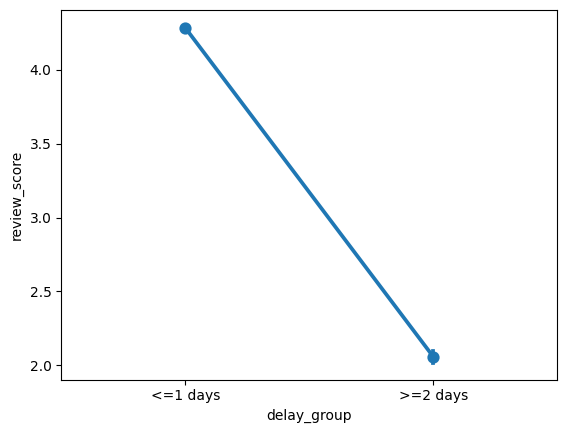

In [ ]:
# 2일 기준 기준 두 그룹의 CI 시각화
df['delay_group'] = np.where(df['delay_days'] >= 2, '>=2 days', '<=1 days')

sns.pointplot(
    data=df,
    x='delay_group',
    y='review_score',
    errorbar=('ci', 95)
)

#### ✅ 통계 검증 결과 요약
대규모 표본(n≈90k)에서는 p-value가 과도하게 작아질 수 있기 때문에<br>
본 분석에서는 통계적 유의성(t-test)과 함께 효과의 크기와 신뢰구간을 시각화 <br>
<br>
=> 배송 지연이 2일 이상 발생한 주문은 리뷰 점수가 평균적으로 약 2점 이상 낮으며<br>
95% 신뢰구간에서도 두 집단 간 차이가 명확히 분리됨을 확인<br>
배송지연 2일 차를 비즈니스 KPI로 정의할 수 있는 충분한 근거가 됨

## 📌 Result Summary
- 배송 지연 2일 차부터 만족도 하락이 유의미
- 통계적으로 유의하며 효과 크기도 큼
- 배송 지연 ‘발생 여부’보다 ‘지연 일수’가 고객 만족도에 더 중요

## 📌 Limitations & Next Step
- 인과관계는 직접적으로 검증하지 못함
- 다음 단계에서 배송 지연 외 요인(상품 카테고리, 가격, 판매자)을 통제한 분석 필요
- 지연 일수 컷오프 변경에 대한 민감도 분석 수행 가능

## 📌 Business Insight & Action Item
- 골든타임은 24시간<br>
  : 지연 1일 차(D+1)까지는 평점 방어가 가능하나(3.7점), <br>2일 차(D+2) 진입 시 평점이 3.1점으로 급락하며 저평점 비율이 34%까지 치솟음

- 비즈니스 액션
  - 셀러 SLA 관리 지표로서 배송 지연일을 D+2기준으로 관리하는 것을 권장
  - 배송 예정일 초과가 예상되는 시점에 선제적 대응(예시: 포인트 제공)을 통해 불만족을 예방하는 방향을 제안

In [ ]:
# dataframe 저장
df.to_csv(
    f"{path}/datasets/processed/olist_orders_enriched_2.csv"
    , index=False
    , encoding="utf-8-sig"
)